# Import packages

In [1]:
import pandas as pd
import numpy as np
import parse
import re
import seaborn as sns
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt

from ProcessHTML import ProcessHTML
from ExtractRooms import ExtractRooms
from GeneralizeDataset import GeneralizeDataset

# Preprocess dataset
## HTML Texts

In [2]:
filename = "../datasets/PropertyData_wDesc.csv"
data = pd.read_csv(filename, encoding="ISO8859-1")

In [3]:
handler = ProcessHTML()

rooms = data["EweMove Description S3 Rooms"]
price = data["Price / Rent"]

for room in rooms:
    handler.EweMove_Description_S3_Rooms(room)
for p in price:
    handler.price_rent(p)

In [24]:
indices = set(range(len(data)))
room_indices = set(i for i in range(len(handler.s3_rooms)) if handler.s3_rooms[i] is not None)
price_indices = set(i for i in range(len(handler.price_or_rent)) if handler.price_or_rent[i][0] > 10)

In [25]:
valid_indices = indices & room_indices & price_indices

## Categorical data

In [26]:
generalize = GeneralizeDataset(data)

parking = generalize.get_feature_num("parking")
outside = generalize.get_feature_num("outside_space")
heating = generalize.get_feature_num("heating")
accessibility = generalize.get_feature_num("accessibility")

In [27]:
condition_indices = set(i for i in indices if data["RTD3316_condition1 - Condition Description"].notna()[i])
qualifier_indices = set(i for i in indices if data["Price Qualifier"].notna()[i])
council_tax_indices = set(i for i in indices if data["DESC Council Tax Band"].notna()[i])

In [28]:
valid_indices = valid_indices & condition_indices & qualifier_indices & council_tax_indices

# Obtain the dataset for model input

In [29]:
parking_names = [i for i in data.columns if "parking" in i]
outside_names = [i for i in data.columns if "outside" in i]
heating_names = [i for i in data.columns if "heating" in i]
accessibility_names = [i for i in data.columns if "accessibility" in i]
condition_names = [i for i in data.columns if "condition" in i]
column_names = ["Postcode", "Sale or Let", "EweMove Description S3 Rooms", "Price / Rent",
                "Price Qualifier", "DESC Council Tax Band", "# of Enquiry or viewings", "# of Apps/Offers"]
column_names += parking_names + outside_names + heating_names + accessibility_names + condition_names

valid_indices = sorted(list(valid_indices))
input_data = data.iloc[valid_indices][column_names]
input_data.head()

,Postcode,Sale or Let,EweMove Description S3 Rooms,Price / Rent,Price Qualifier,DESC Council Tax Band,# of Enquiry or viewings,# of Apps/Offers,RTD3307_parking1 - Parking Description,RTD3307_parking2 - Parking Description,...,RTD3308_outside_space1 - Outside Space Description,RTD3308_outside_space2 - Outside Space Description,RTD3308_outside_space3 - Outside Space Description,RTD3318_heating1 - Heating Description,RTD3318_heating2 - Heating Description,RTD3318_heating3 - Heating Description,RTD3317_accessibility1 - accessibility Description,RTD3317_accessibility2 - accessibility Description,RTD3317_accessibility3 - accessibility Description,RTD3316_condition1 - Condition Description
0,LU7 4WN,Sale,This home includes:<ul><li><strong>01 - Entran...,"<font color='blue'>&pound;140,000</font><br>Of...",Offers In Excess Of,Band B,32,12,Allocated,Off Street,...,Communal Garden,NaN,NaN,Double Glazing,Electric,Night Storage,Not suitable for wheelchair users,NaN,NaN,Good
2,DA17 5PJ,Sale,This home includes:<ul><li><strong>01 - Entran...,"<font color='blue'>&pound;325,000</font><br>Gu...",Guide Price,Band D,14,4,On Street,NaN,...,Rear Garden,Private Garden,NaN,Central,Gas Central,Double Glazing,NaN,NaN,NaN,Good
6,RG26 5PX,Sale,This home includes:<ul><li><strong>01 - Living...,"<font color='blue'>&pound;500,000</font><br>Gu...",Guide Price,Band E,10,2,Driveway,Garage,...,Back Garden,Enclosed Garden,Patio,Double Glazing,Gas Central,Under Floor,NaN,NaN,NaN,Good
7,BD8 0HT,Sale,This home includes:<ul><li><strong>01 - Hallwa...,"<font color='blue'>&pound;170,000</font><br>Of...",Offers in Region Of,Band B,9,1,Driveway,NaN,...,Front Garden,Rear Garden,NaN,Gas Central,NaN,NaN,Level access,NaN,NaN,Good
15,HU17 7AB,Sale,This home includes:<ul><li><strong>01 - Entran...,"<font color='blue'>&pound;410,000</font><br>Of...",Offers Over,Band B,1,2,Off Street,Allocated,...,Rear Garden,NaN,NaN,Gas Central,NaN,NaN,Level access,NaN,NaN,Good


In [30]:
general_data = input_data.loc[:, ~input_data.columns.isin(["EweMove Description S3 Rooms", "Price / Rent"])]
general_data.head()

,Postcode,Sale or Let,Price Qualifier,DESC Council Tax Band,# of Enquiry or viewings,# of Apps/Offers,RTD3307_parking1 - Parking Description,RTD3307_parking2 - Parking Description,RTD3307_parking3 - Parking Description,RTD3308_outside_space1 - Outside Space Description,RTD3308_outside_space2 - Outside Space Description,RTD3308_outside_space3 - Outside Space Description,RTD3318_heating1 - Heating Description,RTD3318_heating2 - Heating Description,RTD3318_heating3 - Heating Description,RTD3317_accessibility1 - accessibility Description,RTD3317_accessibility2 - accessibility Description,RTD3317_accessibility3 - accessibility Description,RTD3316_condition1 - Condition Description
0,LU7 4WN,Sale,Offers In Excess Of,Band B,32,12,Allocated,Off Street,Residents,Communal Garden,NaN,NaN,Double Glazing,Electric,Night Storage,Not suitable for wheelchair users,NaN,NaN,Good
2,DA17 5PJ,Sale,Guide Price,Band D,14,4,On Street,NaN,NaN,Rear Garden,Private Garden,NaN,Central,Gas Central,Double Glazing,NaN,NaN,NaN,Good
6,RG26 5PX,Sale,Guide Price,Band E,10,2,Driveway,Garage,Off Street,Back Garden,Enclosed Garden,Patio,Double Glazing,Gas Central,Under Floor,NaN,NaN,NaN,Good
7,BD8 0HT,Sale,Offers in Region Of,Band B,9,1,Driveway,NaN,NaN,Front Garden,Rear Garden,NaN,Gas Central,NaN,NaN,Level access,NaN,NaN,Good
15,HU17 7AB,Sale,Offers Over,Band B,1,2,Off Street,Allocated,NaN,Rear Garden,NaN,NaN,Gas Central,NaN,NaN,Level access,NaN,NaN,Good


## Price for sale and rental

In [31]:
prices = [handler.price_or_rent[i][0] for i in valid_indices]
prices = pd.DataFrame(prices)
rename_dict = {i: j for i, j in zip(range(len(prices)), valid_indices)}
prices = prices.rename(index=rename_dict)

### Sale price

Text(0.5, 1.0, 'The Distribution of Sale Price (Outliers removed)')

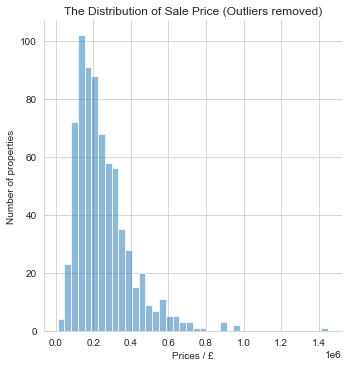

In [41]:
sale_prices = prices[general_data["Sale or Let"] == "Sale"]
fig = sns.displot(sale_prices)
fig._legend.remove()
plt.xlabel("Prices / £")
plt.ylabel("Number of properties")
plt.title("The Distribution of Sale Price (Outliers removed)")

Text(0.5, 1.0, 'The Distribution of Rental Price (Outliers removed)')

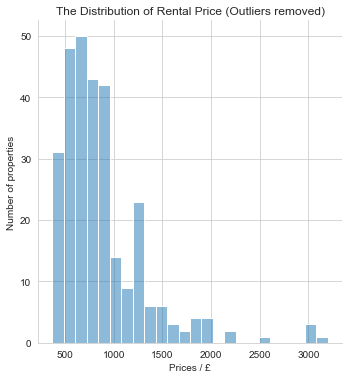

In [40]:
rental_price = prices[general_data["Sale or Let"] == "Rental"]
fig = sns.displot(rental_price)
fig._legend.remove()
plt.xlabel("Prices / £")
plt.ylabel("Number of properties")
plt.title("The Distribution of Rental Price (Outliers removed)")

## Extract room information

In [ ]:
rooms = [handler.s3_rooms[i] for i in valid_indices]
extract_room = ExtractRooms(rooms, handler.s3_rooms_set, "{} ({} sqm){}")

### Bedrooms

In [ ]:
bedrooms = extract_room.get_rooms("bedroom")

In [ ]:
bedrooms = pd.DataFrame(bedrooms)
rename_dict = {str(i): "bedroom {}".format(i + 1) for i in range(6)}
bedrooms = bedrooms.rename(columns=rename_dict)
bedrooms.head()

### Kitchens

In [ ]:
kitchens = extract_room.get_rooms("kitchen", operation="number")

In [ ]:
kitchens = pd.DataFrame(kitchens)
kitchens = kitchens.rename(columns={0: "kitchen number"})
kitchens.head()

### Living/Reception

In [ ]:
receptions = extract_room.get_rooms("living", "reception", operation="sum")

In [ ]:
receptions = pd.DataFrame(receptions)
receptions = receptions.rename(columns={0: "living area"})
receptions.head()

### Bathrooms

In [ ]:
bathrooms = extract_room.get_rooms("bathroom", "wc", "washroom", operation="number")

In [ ]:
bathrooms = pd.DataFrame(bathrooms)
bathrooms = bathrooms.rename(columns={0: "bathroom number"})
bathrooms.head()

### Dining

In [ ]:
dining_rooms = extract_room.get_rooms("dining", operation="number")

In [ ]:
dining_rooms = pd.DataFrame(dining_rooms)
dining_rooms = dining_rooms.rename(columns={0: "dining number"})
dining_rooms.head()

### Other spaces

In [ ]:
others = extract_room.get_rest_rooms()

In [ ]:
others = pd.DataFrame(others)
others = others.rename(columns={0: "other number", 1: "other area"})
others.head()

In [ ]:
room_info = pd.concat([bedrooms, kitchens, receptions, bathrooms, dining_rooms, others], axis=1)
room_info.head()